# **Image classification for Fashion MNIST dataset**

In [1]:
# Import libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchsummary import summary
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading the dataset
dataset = FashionMNIST(root = 'data/', download = True, transform = ToTensor())
test_dataset = FashionMNIST(root = 'data/', train = False, transform = ToTensor())

In [3]:
# Length of the training and the test datasets
print(len(dataset))
print(len(test_dataset))

60000
10000


In [4]:
# Names of classes
classes = dataset.classes
print('Number of Classes:', len(classes))
print('Class Names :\n', classes)

Number of Classes: 10
Class Names :
 ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [5]:
# Set manual_seed
torch.manual_seed(1763547) # Reproducibility
val_size = 10000
train_size = len(dataset) - val_size

In [6]:
# Random Split and Split of dataset between train and validation
train_ds, val_ds = random_split(dataset,[train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [7]:
# shape of the image 
img,label=train_ds[0]
img.shape

torch.Size([1, 28, 28])

In [8]:
# Batch Size
batch_size = 128

In [9]:
# Defininf Loaders for training process
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers=4, pin_memory =True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory =True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory =True)

Shape of an Image (Batch Size, RGB, Pixels): torch.Size([128, 1, 28, 28])


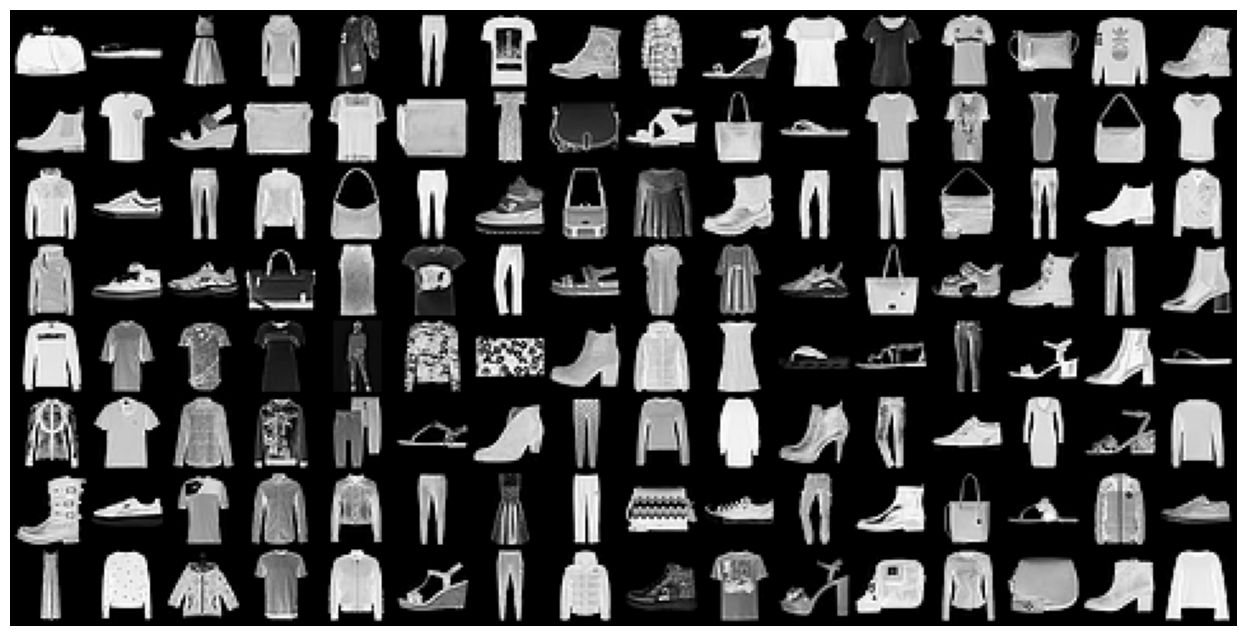

In [10]:
# Visualization of batch grid
for images, _ in train_loader:
    print('Shape of an Image (Batch Size, RGB, Pixels):', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [12]:
device = get_default_device()
device

device(type='cpu')

In [13]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [15]:
# Defining the base of the models with common procedures
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [16]:
# Convolutional Neural Network 
class FashionMNISTCnnModel(ImageClassificationBase): 
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, xb):
        return self.network(xb)

In [17]:
# fit and evaluation functions for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
model_cnn =  to_device(FashionMNISTCnnModel(), device)
model_cnn

FashionMNISTCnnModel(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=3136, out_features=128, bias=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [19]:
# Initial results before training:
history_cnn = [evaluate(model_cnn, val_loader)]
history_cnn

[{'val_loss': 2.303478479385376, 'val_acc': 0.05290743708610535}]

In [20]:
# Model hyperparameters and optimizer:
num_epochs_cnn = [10, 5]
opt_func = torch.optim.Adam # Change also the optimizer
lr_cnn = [0.001 , 0.0001]

In [21]:
%%time
history_cnn += fit(num_epochs_cnn[0], lr_cnn[0], model_cnn, train_loader, val_loader, opt_func)

Epoch [0], val_loss: 0.3631, val_acc: 0.8687
Epoch [1], val_loss: 0.3022, val_acc: 0.8904
Epoch [2], val_loss: 0.2808, val_acc: 0.8963
Epoch [3], val_loss: 0.2612, val_acc: 0.9057
Epoch [4], val_loss: 0.2359, val_acc: 0.9137
Epoch [5], val_loss: 0.2415, val_acc: 0.9151
Epoch [6], val_loss: 0.2555, val_acc: 0.9119
Epoch [7], val_loss: 0.2257, val_acc: 0.9202
Epoch [8], val_loss: 0.2327, val_acc: 0.9152
Epoch [9], val_loss: 0.2516, val_acc: 0.9188
CPU times: user 31min 26s, sys: 1h 13min 11s, total: 1h 44min 37s
Wall time: 9min 41s


In [22]:
%%time
history_cnn += fit(num_epochs_cnn[1], lr_cnn[1], model_cnn, train_loader, val_loader, opt_func)

Epoch [0], val_loss: 0.2429, val_acc: 0.9272
Epoch [1], val_loss: 0.2545, val_acc: 0.9260
Epoch [2], val_loss: 0.2645, val_acc: 0.9261
Epoch [3], val_loss: 0.2664, val_acc: 0.9250
Epoch [4], val_loss: 0.2809, val_acc: 0.9265
CPU times: user 15min 42s, sys: 36min 36s, total: 52min 19s
Wall time: 4min 51s


In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs');

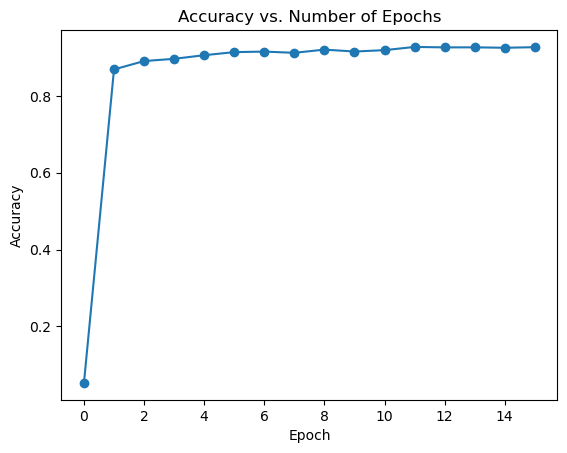

In [24]:
# Plot Accuracy of the model:
plot_accuracies(history_cnn)

In [25]:
# plot losses of the model
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bo')
    plt.plot(val_losses, '-ro')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Number of epochs');

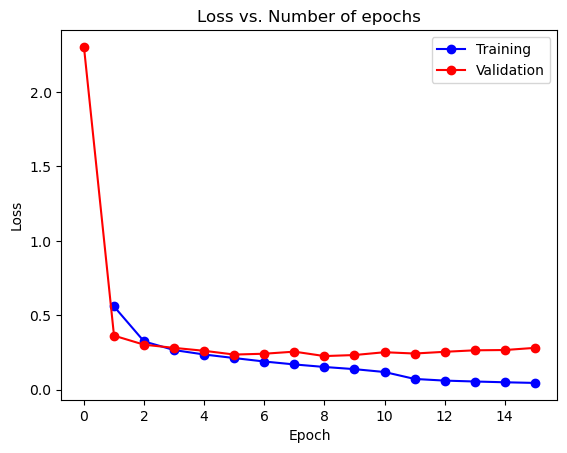

In [26]:
plot_losses(history_cnn)

In [27]:
# evaluation of the CNN Model with the test dataset:
test_cnn = evaluate(model_cnn, test_loader) #final evaluation of cnn model with test dataset
test_cnn

{'val_loss': 0.2822931408882141, 'val_acc': 0.9276107549667358}

In [28]:
test_loss_cnn = test_cnn['val_loss']
test_acc_cnn = test_cnn['val_acc']
print('test_loss_cnn:', test_cnn['val_loss'])
print('test_acc_cnn:', test_cnn['val_acc'])

test_loss_cnn: 0.2822931408882141
test_acc_cnn: 0.9276107549667358


In [29]:
torch.save(model_cnn.state_dict(), 'cnn.pth')

In [30]:
input_size = (1, 28, 28)
summary(model_cnn,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           9,248
              ReLU-4           [-1, 32, 28, 28]               0
         MaxPool2d-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 64, 14, 14]          18,496
              ReLU-7           [-1, 64, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          36,928
              ReLU-9           [-1, 64, 14, 14]               0
        MaxPool2d-10             [-1, 64, 7, 7]               0
          Flatten-11                 [-1, 3136]               0
           Linear-12                  [-1, 128]         401,536
             ReLU-13                  [-1, 128]               0
           Linear-14                   

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to generate predictions
def get_predictions(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Predictions and true labels
predictions, true_labels = get_predictions(model_cnn, test_loader)

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.88      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.86      0.89      0.88      1000
       Dress       0.94      0.93      0.93      1000
        Coat       0.87      0.90      0.88      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.80      0.77      0.78      1000
     Sneaker       0.97      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



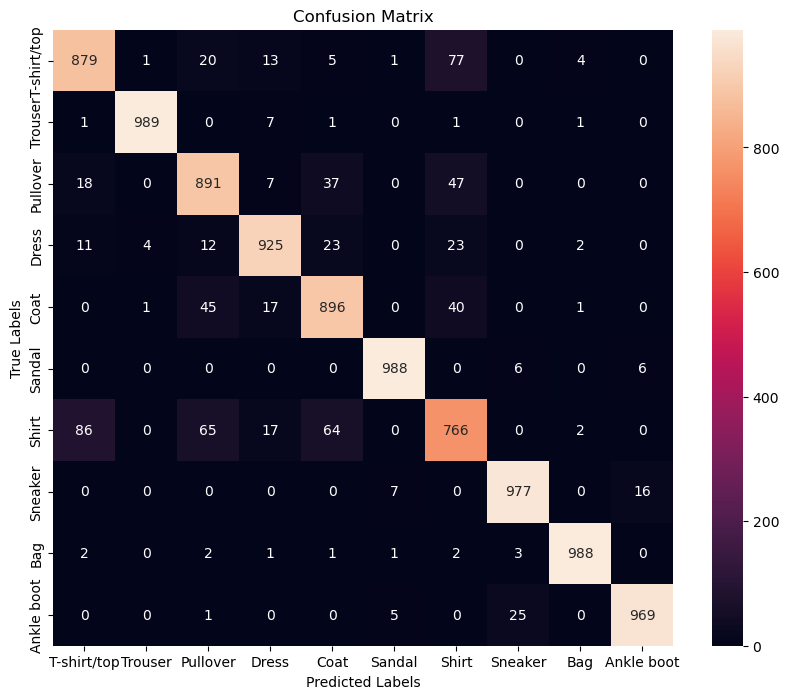

In [32]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [33]:
class LeNet(ImageClassificationBase):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),  # Adjust input size based on Fashion MNIST (28x28 images)
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [34]:
# evaluate and fit functions are defined
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [35]:
# Create the LeNet model 
model_lenet = to_device(LeNet(10), device)

# Evaluate the LeNet model on the validation set before training
history_lenet = [evaluate(model_lenet, val_loader)]

In [36]:
# Define the number of epochs, learning rate, and other training parameters
epochs_lenet = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [37]:
# Train the LeNet model
history_lenet += fit_one_cycle(epochs_lenet, max_lr, model_lenet, train_loader, val_loader,
                               grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], val_loss: 0.6380, val_acc: 0.7485
Epoch [1], val_loss: 0.4315, val_acc: 0.8486
Epoch [2], val_loss: 0.4043, val_acc: 0.8532
Epoch [3], val_loss: 0.3905, val_acc: 0.8552
Epoch [4], val_loss: 0.3582, val_acc: 0.8697
Epoch [5], val_loss: 0.3612, val_acc: 0.8687
Epoch [6], val_loss: 0.3349, val_acc: 0.8813
Epoch [7], val_loss: 0.3362, val_acc: 0.8841
Epoch [8], val_loss: 0.3268, val_acc: 0.8881
Epoch [9], val_loss: 0.3110, val_acc: 0.8900
Epoch [10], val_loss: 0.2983, val_acc: 0.8959
Epoch [11], val_loss: 0.3069, val_acc: 0.8992
Epoch [12], val_loss: 0.3076, val_acc: 0.8984
Epoch [13], val_loss: 0.3162, val_acc: 0.8988
Epoch [14], val_loss: 0.3160, val_acc: 0.8997


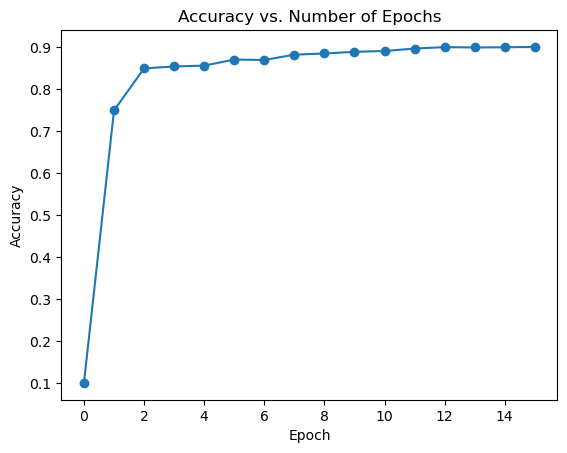

In [38]:
# Plot accuracy and losses
plot_accuracies(history_lenet)

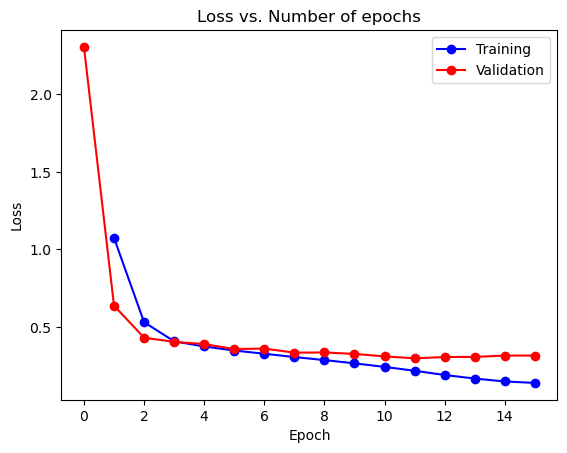

In [39]:
plot_losses(history_lenet)

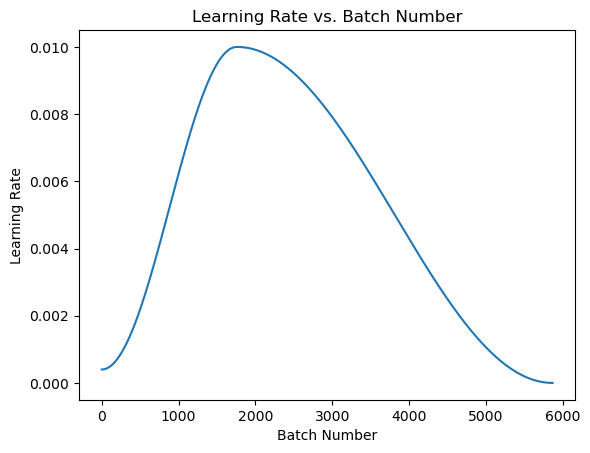

In [40]:
# plot learning rates over time
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch Number')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Batch Number');

plot_lrs(history_lenet)

In [41]:
# Evaluate the LeNet model on the test set
test_lenet = evaluate(model_lenet, test_loader)

In [42]:
# Test loss and accuracy
test_loss_lenet = test_lenet['val_loss']
test_acc_lenet = test_lenet['val_acc']

print('Test Loss (LeNet):', test_loss_lenet)
print('Test Accuracy (LeNet):', test_acc_lenet)

Test Loss (LeNet): 0.3072781562805176
Test Accuracy (LeNet): 0.8995253443717957


In [43]:
# Save the LeNet model's weights
torch.save(model_lenet.state_dict(), 'LeNet.pth')

In [44]:
summary(model_lenet,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
              ReLU-2            [-1, 6, 24, 24]               0
         MaxPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
              ReLU-5             [-1, 16, 8, 8]               0
         MaxPool2d-6             [-1, 16, 4, 4]               0
            Linear-7                  [-1, 120]          30,840
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [45]:
# Predictions and true labels
predictions, true_labels = get_predictions(model_lenet, test_loader)

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.85      0.85      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.84      0.83      0.84      1000
       Dress       0.90      0.91      0.91      1000
        Coat       0.83      0.84      0.84      1000
      Sandal       0.98      0.97      0.97      1000
       Shirt       0.72      0.71      0.71      1000
     Sneaker       0.94      0.96      0.95      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



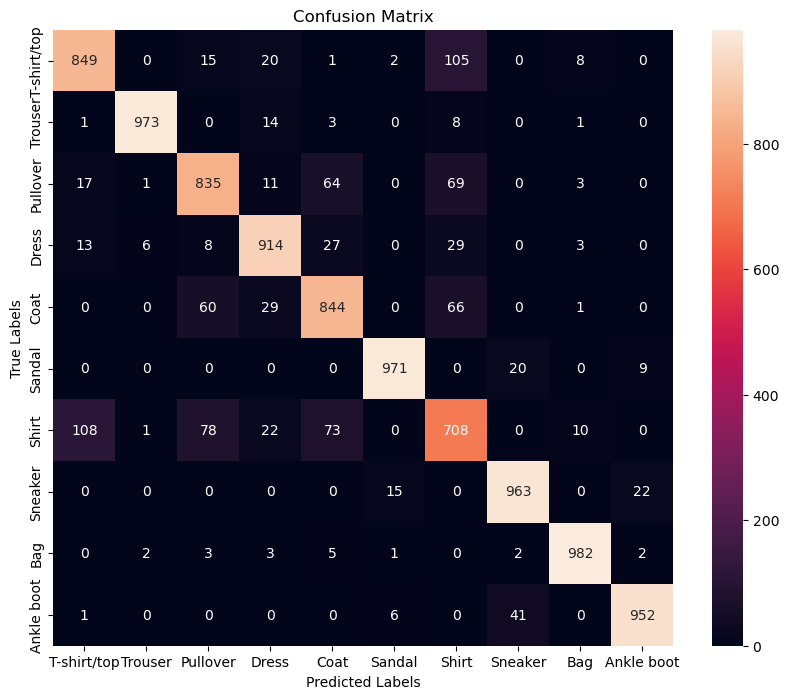

In [46]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()